## Applying Artificial Neural Network Algorithms to the Problem (Stock Time Series Forecasting)

# HYBRID MODEL X2 v05.1

In [44]:
#%pip install keras-tuner
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import MACD
from scipy.stats import zscore
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from sklearn.base import TransformerMixin, BaseEstimator
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, concatenate, Dropout, concatenate, Flatten
from tensorflow.keras.models import Model
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#xXx############################################################################################xXx#
# Function to preprocess and clean the dataset dynamically
def preprocess_data(ticker, start, end, n_timesteps=10, model_type='LSTM'):
    # Download historical data
    df = yf.download(ticker, start=start, end=end)
    
    # Preprocess the data
    df['Date'] = pd.to_datetime(df.index)
    df['Date'] = df['Date'].apply(lambda date: date.timestamp())
    
    # Remove noise and outliers
    z_scores = zscore(df[['Open', 'High', 'Low', 'Close', 'Volume']])
    df = df[(z_scores < 3).all(axis=1)]

    # Feature engineering
    df['Price_Change_Pct'] = df['Close'].pct_change()
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    df['5d_MA'] = df['Close'].rolling(window=5).mean()
    df['20d_MA'] = df['Close'].rolling(window=20).mean()
    df['50d_MA'] = df['Close'].rolling(window=50).mean()
    df['200d_MA'] = df['Close'].rolling(window=200).mean()

    # Technical indicators
    rsi_indicator = RSIIndicator(df['Close'], window=14)
    df['RSI'] = rsi_indicator.rsi()
    bb_indicator = BollingerBands(df['Close'], window=20)
    df['Bollinger_Bands'] = bb_indicator.bollinger_mavg()
    macd_indicator = MACD(df['Close'], window_slow=26, window_fast=12)
    df['MACD'] = macd_indicator.macd()

    # Remove NA values after feature engineering
    df = df.dropna()

    # Split the data into features and target
    X = df[['Price_Change_Pct', 'Log_Returns', '5d_MA', '20d_MA', 'RSI', 'Bollinger_Bands', 'MACD']]
    y = df['Close']

    return X, y

class ReshapeForModel(BaseEstimator, TransformerMixin):
    def __init__(self, n_timesteps=10, model_type='LSTM'):
        self.n_timesteps = n_timesteps
        self.model_type = model_type

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        n_samples, n_features = X.shape
        reshaped_data = []

        # Create rolling windows of size 'n_timesteps'
        for i in range(n_samples - self.n_timesteps + 1):
            reshaped_data.append(X[i:i + self.n_timesteps])
        
        reshaped_data = np.array(reshaped_data)

        # Do NOT add channel dimension for CNN, as Conv1D expects 3D input (n_samples, n_timesteps, n_features)
        if self.model_type == 'CNN':
            return reshaped_data  # Shape: (n_samples, n_timesteps, n_features)
        return reshaped_data  # Same for LSTM


# Dynamic pipeline for preprocessing, scaling, and reshaping
def create_dynamic_pipeline(n_timesteps=10, model_type='LSTM'):
    pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),           # Handle missing values
        ('scaler', MinMaxScaler(feature_range=(0, 1))),        # Normalize data
        ('reshape', ReshapeForModel(n_timesteps=n_timesteps, model_type=model_type))  # Reshape for model
    ])
    return pipeline

# LSTM model creation
def create_lstm_model(n_timesteps, n_features):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Assuming it's a regression task
    model.compile(optimizer='adam', loss='mse')
    return model

def create_cnn_model(n_timesteps, n_features):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dropout(0.2))
    model.add(Flatten())  # Flatten the output to 1D
    model.add(Dense(50, activation='relu'))  # Dense layer with some neurons
    model.add(Dense(1))  # Output single value for regression
    model.compile(optimizer='adam', loss='mse')
    return model

# Combination
def create_hybrid_model(n_timesteps, n_features):
    # CNN branch
    cnn_input = Input(shape=(n_timesteps, n_features))
    cnn_branch = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_input)
    cnn_branch = Flatten()(cnn_branch)  # Flatten to 2D shape (None, units)
    
    # LSTM branch
    lstm_input = Input(shape=(n_timesteps, n_features))
    lstm_branch = LSTM(50, activation='relu')(lstm_input)  # Already 2D output (None, 50)
    
    # Combine CNN and LSTM branches
    combined = concatenate([cnn_branch, lstm_branch])
    
    # Add a Dropout layer for regularization
    combined = Dropout(0.2)(combined)
    
    # Output layer (for regression)
    output = Dense(1)(combined)
    
    # Build model
    model = Model(inputs=[cnn_input, lstm_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    
    return model
#xXx############################################################################################xXx#

# Set up the pipeline and models
ticker = "BTC-USD"
start = "2000-01-01"
end = (datetime.today()) # - timedelta(days=5)).strftime("%Y-%m-%d")

# Preprocess and split the data
X, y = preprocess_data(ticker, start=start, end=end)

# Create the pipeline for LSTM
pipeline_lstm = create_dynamic_pipeline(n_timesteps=10, model_type='LSTM')
X_lstm_processed = pipeline_lstm.fit_transform(X)

# Train your LSTM model
lstm_model = create_lstm_model(n_timesteps=10, n_features=X_lstm_processed.shape[2])
lstm_model.fit(X_lstm_processed, y[9:], epochs=10, batch_size=32, verbose=0)

# Create the pipeline for CNN
pipeline_cnn = create_dynamic_pipeline(n_timesteps=10, model_type='CNN')
X_cnn_processed = pipeline_cnn.fit_transform(X)

# Train your CNN model
cnn_model = create_cnn_model(n_timesteps=10, n_features=X_cnn_processed.shape[2])
cnn_model.fit(X_cnn_processed, y[9:], epochs=10, batch_size=32, verbose=0)


[*********************100%***********************]  1 of 1 completed


In [45]:
# Split your data for LSTM
X_train_lstm, X_test_lstm, y_train, y_test = train_test_split(X_lstm_processed, y[9:], test_size=0.2, shuffle=False)

# Train your LSTM model
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=128,verbose=0)

# Predict with LSTM
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Calculate scores for LSTM
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

###################################################################################################################

# Split your data for CNN
X_train_cnn, X_test_cnn, _, _ = train_test_split(X_cnn_processed, y[9:], test_size=0.2, shuffle=False)

# Train your CNN model
cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=64,verbose=0)

# Predict with CNN
y_pred_cnn = cnn_model.predict(X_test_cnn)

# Calculate scores for CNN
y_pred_cnn = np.squeeze(y_pred_cnn)
mse_cnn = np.mean((y_test - y_pred_cnn) ** 2)
mae_cnn = np.mean(np.abs(y_test - y_pred_cnn))
r2_cnn = np.corrcoef(y_test, y_pred_cnn)[0, 1] ** 2

###################################################################################################################

# Split your data for the hybrid model (both LSTM and CNN inputs)
X_train_lstm, X_test_lstm, y_train, y_test = train_test_split(X_lstm_processed, y[9:], test_size=0.2, shuffle=False)
X_train_cnn, X_test_cnn, _, _ = train_test_split(X_cnn_processed, y[9:], test_size=0.2, shuffle=False)

# Train the Hybrid model
hybrid_model.fit([X_train_cnn, X_train_lstm], y_train, epochs=10, batch_size=64,verbose=0)

# Predict with the Hybrid model
y_pred_hybrid = hybrid_model.predict([X_test_cnn, X_test_lstm])

# Calculate scores for Hybrid model
mse_hybrid = mean_squared_error(y_test, y_pred_hybrid)
mae_hybrid = mean_absolute_error(y_test, y_pred_hybrid)
r2_hybrid = r2_score(y_test, y_pred_hybrid)

print(f"LSTM Model - MSE: {mse_lstm}, MAE: {mae_lstm}, R2: {r2_lstm}")
print(f"CNN Model - MSE: {mse_cnn}, MAE: {mae_cnn}, R2: {r2_cnn}")
print(f"Hybrid Model - MSE: {mse_hybrid}, MAE: {mae_hybrid}, R2: {r2_hybrid}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
LSTM Model - MSE: 15471543.767032824, MAE: 2703.4698895591437, R2: 0.950410196375411
CNN Model - MSE: 9745172.506071592, MAE: 2163.271164051161, R2: 0.9722383675898011
Hybrid Model - MSE: 14361703.74377392, MAE: 2831.1585985690313, R2: 0.9539674851396643


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


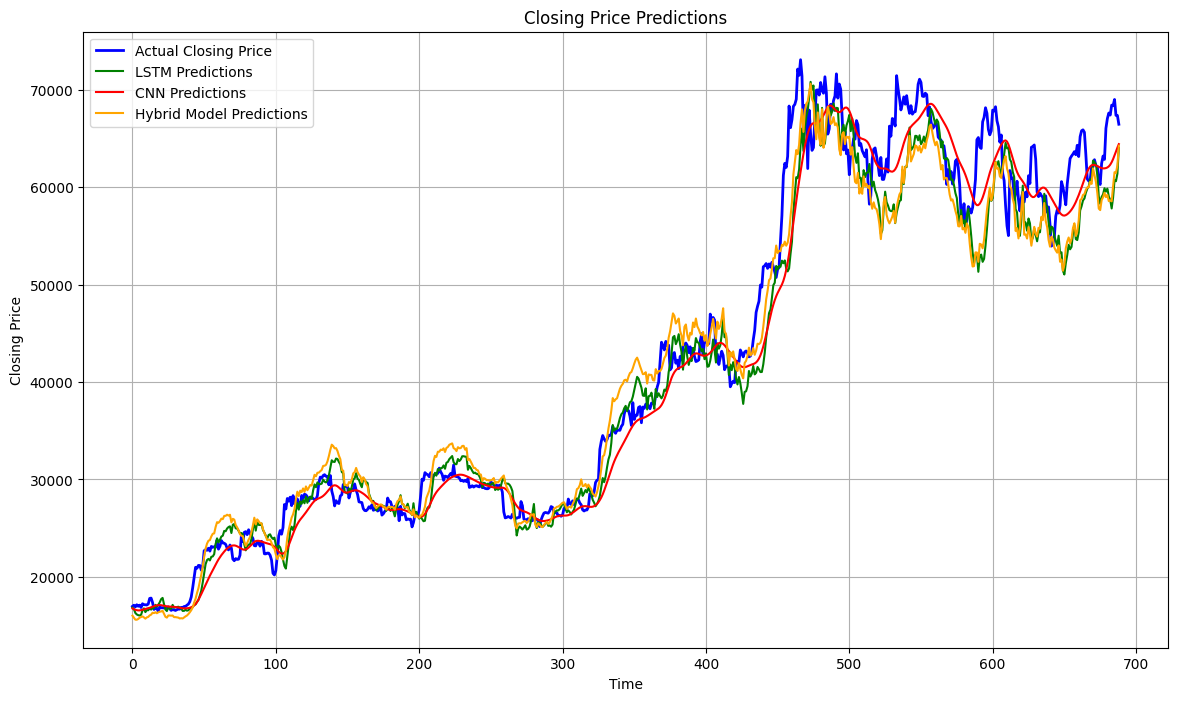

In [46]:
# Function to plot actual vs predictions
def plot_timeseries_predictions(y_test, y_pred_lstm, y_pred_cnn, y_pred_hybrid, title='Closing Price Predictions'):
    plt.figure(figsize=(14, 8))
    
    # Create a time axis based on the test set length
    time_axis = range(len(y_test))

    # Plot actual closing prices (ground truth)
    plt.plot(time_axis, y_test, label='Actual Closing Price', color='blue', linewidth=2)

    # Plot LSTM predictions
    plt.plot(time_axis, y_pred_lstm, label='LSTM Predictions', color='green', linestyle='-')

    # Plot CNN predictions
    plt.plot(time_axis, y_pred_cnn, label='CNN Predictions', color='red', linestyle='-')

    # Plot Hybrid model predictions
    plt.plot(time_axis, y_pred_hybrid, label='Hybrid Model Predictions', color='orange', linestyle='-')

    # Title and labels
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming predictions for all models are generated
y_pred_lstm = lstm_model.predict(X_test_lstm)
y_pred_cnn = cnn_model.predict(X_test_cnn)
y_pred_hybrid = hybrid_model.predict([X_test_cnn, X_test_lstm])

# Squeeze predictions to match the shape of y_test
y_pred_lstm = np.squeeze(y_pred_lstm)
y_pred_cnn = np.squeeze(y_pred_cnn)
y_pred_hybrid = np.squeeze(y_pred_hybrid)

# Call the function to plot the time series
plot_timeseries_predictions(y_test, y_pred_lstm, y_pred_cnn, y_pred_hybrid)

In [47]:
X_test_lstm.shape, X_test_cnn.shape

((689, 10, 7), (689, 10, 7))

In [48]:
def predict_future_5_days(model, X_last_steps, n_timesteps=10, n_features=7, hybrid=False):
    predictions = []
    
    # For hybrid models, we expect X_last_steps to be a list with two inputs
    if hybrid:
        current_input_cnn, current_input_lstm = X_last_steps  # Unpack the CNN and LSTM inputs
    else:
        current_input = X_last_steps.reshape(1, n_timesteps, n_features)  # Ensure correct input shape for non-hybrid models
    
    for _ in range(5):
        if hybrid:
            # Make a prediction for the next day using both CNN and LSTM inputs
            next_pred = model.predict([current_input_cnn, current_input_lstm])
            current_input_cnn = np.roll(current_input_cnn, -1, axis=1)  # Shift the window for the CNN input
            current_input_lstm = np.roll(current_input_lstm, -1, axis=1)  # Shift the window for the LSTM input
        else:
            # Make a prediction for the next day for non-hybrid models
            next_pred = model.predict(current_input)
            current_input = np.roll(current_input, -1, axis=1)  # Shift the window

        # Append the prediction
        predictions.append(next_pred[0])

    return np.array(predictions).flatten()

# Use the last 10 timesteps directly for LSTM and CNN predictions
X_last_lstm = X_test_lstm[-1:]  # Shape will be (1, 10, 7)
X_last_cnn = X_test_cnn[-1:]    # Shape will be (1, 10, 7)

# Predict the next 5 days for LSTM
future_lstm_predictions = predict_future_5_days(lstm_model, X_last_lstm, n_timesteps=10, n_features=7)

# Predict the next 5 days for CNN
future_cnn_predictions = predict_future_5_days(cnn_model, X_last_cnn, n_timesteps=10, n_features=7)

# Predict the next 5 days for the Hybrid Model (use hybrid=True)
future_hybrid_predictions = predict_future_5_days(hybrid_model, [X_last_cnn, X_last_lstm], n_timesteps=10, n_features=7, hybrid=True)

# Display predictions
print("LSTM Predictions for next 5 days:", future_lstm_predictions)
print("CNN Predictions for next 5 days:", future_cnn_predictions)
print("Hybrid Model Predictions for next 5 days:", future_hybrid_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
LSTM Predictions for next 5 days: [64033.598 63926.066 64310.215 64640.53  65599.49 ]
CNN Predictions for next 5 days: [64419.    64591.53  64598.64  64470.016 64361.996]
Hybrid Model Predictions for next 5 days: [64252.613 63619.008 63779.492 63978.363 64669.3  ]


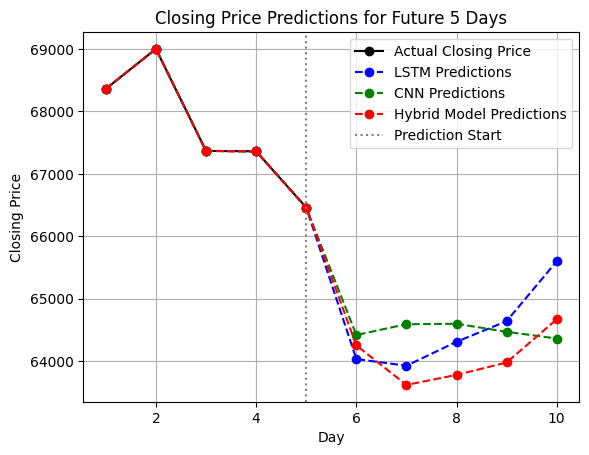

In [49]:
# Assuming 'y_test' contains the actual closing prices
last_5_actual = y_test[-5:]

# Convert predictions to a flat array if they aren't already
future_lstm_predictions = np.array(future_lstm_predictions).flatten()
future_cnn_predictions = np.array(future_cnn_predictions).flatten()
future_hybrid_predictions = np.array(future_hybrid_predictions).flatten()

# Extend the range for plotting (for 10 days: last 5 actual + next 5 predictions)
days = range(1, 11)  # Total 10 days (5 actual + 5 future)

# Combine the actual last 5 days with the predicted 5 days for each model
actual_and_lstm = np.concatenate([last_5_actual, future_lstm_predictions])
actual_and_cnn = np.concatenate([last_5_actual, future_cnn_predictions])
actual_and_hybrid = np.concatenate([last_5_actual, future_hybrid_predictions])

# Plot the actual closing prices (first 5 days)
plt.plot(days[:5], last_5_actual, label='Actual Closing Price', marker='o', color='black')

# Plot the predictions starting from day 6 to day 10
plt.plot(days, actual_and_lstm, label='LSTM Predictions', marker='o', linestyle='--', color='blue')
plt.plot(days, actual_and_cnn, label='CNN Predictions', marker='o', linestyle='--', color='green')
plt.plot(days, actual_and_hybrid, label='Hybrid Model Predictions', marker='o', linestyle='--', color='red')

# Add titles and labels
plt.title('Closing Price Predictions for Future 5 Days')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.axvline(x=5, linestyle=':', color='gray', label='Prediction Start')  # Line to separate actual from predicted
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [50]:
# Define n_timesteps and n_features globally based on your data shape
n_timesteps = X_train_lstm.shape[1]  # Number of timesteps in your data
n_features = X_train_lstm.shape[2]   # Number of features in your data

# Define the Hybrid Model
def build_hybrid_model(hp):
    # LSTM part of the hybrid model
    lstm_input = Input(shape=(n_timesteps, n_features))
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32) # 128
    lstm_output = LSTM(units=lstm_units, activation='relu')(lstm_input)
    lstm_dropout = hp.Float('lstm_dropout', min_value=0.0, max_value=0.5, step=0.1)
    lstm_output = Dropout(lstm_dropout)(lstm_output)
    
    # CNN part of the hybrid model
    cnn_input = Input(shape=(n_timesteps, n_features))
    cnn_filters = hp.Int('cnn_filters', min_value=32, max_value=128, step=32)
    cnn_output = Conv1D(filters=cnn_filters, kernel_size=3, activation='relu')(cnn_input)
    cnn_dropout = hp.Float('cnn_dropout', min_value=0.0, max_value=0.5, step=0.1)
    cnn_output = Dropout(cnn_dropout)(cnn_output)
    cnn_output = LSTM(units=lstm_units, activation='relu')(cnn_output)  # Add LSTM after CNN layers

    # Merge the outputs
    merged = concatenate([lstm_output, cnn_output])
    
    # Final output layer
    output = Dense(1)(merged)
    
    # Build the model
    model = Model(inputs=[lstm_input, cnn_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    
    return model

# Tuning with Bayesian Optimization
tuner = kt.BayesianOptimization(
    build_hybrid_model,
    objective='val_loss',  # We want to minimize validation loss
    max_trials=10,  # Try 10 different combinations
    executions_per_trial=2,  # For stability, test each configuration twice
    directory='hybrid_tuning',
    project_name='stock_hybrid'
)

# Split your data for LSTM and CNN
X_train_lstm, X_test_lstm, y_train, y_test = train_test_split(X_lstm_processed, y[9:], test_size=0.2, shuffle=False)
X_train_cnn, X_test_cnn, _, _ = train_test_split(X_cnn_processed, y[9:], test_size=0.2, shuffle=False)

# Run the hyperparameter search
tuner.search([X_train_lstm, X_train_cnn], y_train, epochs=10, validation_data=([X_test_lstm, X_test_cnn], y_test))

# Get the best model
best_hybrid_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
best_hybrid_model.evaluate([X_test_lstm, X_test_cnn], y_test)

Reloading Tuner from hybrid_tuning\stock_hybrid\tuner0.json
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5580922.5000


10014200.0

In [51]:
# Add the new tuned Best Hybrid Model
# best_hybrid_model is already trained after Bayesian Optimization

# Predict with the Best Hybrid Model
y_pred_best_hybrid = best_hybrid_model.predict([X_test_cnn, X_test_lstm])

# Calculate scores for Best Hybrid Model
mse_best_hybrid = mean_squared_error(y_test, y_pred_best_hybrid)
mae_best_hybrid = mean_absolute_error(y_test, y_pred_best_hybrid)
r2_best_hybrid = r2_score(y_test, y_pred_best_hybrid)

# Print the results for all models
print(f"LSTM Model - MSE: {mse_lstm}, MAE: {mae_lstm}, R2: {r2_lstm}")
print(f"CNN Model - MSE: {mse_cnn}, MAE: {mae_cnn}, R2: {r2_cnn}")
print(f"Original Hybrid Model - MSE: {mse_hybrid}, MAE: {mae_hybrid}, R2: {r2_hybrid}")
print(f"Best Hybrid Model - MSE: {mse_best_hybrid}, MAE: {mae_best_hybrid}, R2: {r2_best_hybrid}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
LSTM Model - MSE: 15471543.767032824, MAE: 2703.4698895591437, R2: 0.950410196375411
CNN Model - MSE: 9745172.506071592, MAE: 2163.271164051161, R2: 0.9722383675898011
Original Hybrid Model - MSE: 14361703.74377392, MAE: 2831.1585985690313, R2: 0.9539674851396643
Best Hybrid Model - MSE: 10014200.387605269, MAE: 2316.719498367199, R2: 0.9679022185402855


In [52]:
def predict_future_5_days(model, X_last_steps, n_timesteps=10, n_features=7, hybrid=False):
    predictions = []
    
    # For hybrid models, we expect X_last_steps to be a list with two inputs (CNN and LSTM)
    if hybrid:
        current_input_cnn, current_input_lstm = X_last_steps  # Unpack the CNN and LSTM inputs
    else:
        current_input = X_last_steps.reshape(1, n_timesteps, n_features)  # Ensure correct input shape for non-hybrid models
    
    for _ in range(5):
        if hybrid:
            # Make a prediction for the next day using both CNN and LSTM inputs
            next_pred = model.predict([current_input_cnn, current_input_lstm])
            current_input_cnn = np.roll(current_input_cnn, -1, axis=1)  # Shift the window for the CNN input
            current_input_lstm = np.roll(current_input_lstm, -1, axis=1)  # Shift the window for the LSTM input
        else:
            # Make a prediction for the next day for non-hybrid models
            next_pred = model.predict(current_input)
            current_input = np.roll(current_input, -1, axis=1)  # Shift the window

        # Append the prediction
        predictions.append(next_pred[0])

    return np.array(predictions).flatten()

# Use the last 10 timesteps directly for LSTM and CNN predictions
X_last_lstm = X_test_lstm[-1:]  # Shape will be (1, 10, 7)
X_last_cnn = X_test_cnn[-1:]    # Shape will be (1, 10, 7)

# Predict the next 5 days for LSTM
future_lstm_predictions = predict_future_5_days(lstm_model, X_last_lstm, n_timesteps=10, n_features=7)

# Predict the next 5 days for CNN
future_cnn_predictions = predict_future_5_days(cnn_model, X_last_cnn, n_timesteps=10, n_features=7)

# Predict the next 5 days for the Original Hybrid Model (use hybrid=True)
future_hybrid_predictions = predict_future_5_days(hybrid_model, [X_last_cnn, X_last_lstm], n_timesteps=10, n_features=7, hybrid=True)

# Predict the next 5 days for the Best Hybrid Model (use hybrid=True)
future_best_hybrid_predictions = predict_future_5_days(best_hybrid_model, [X_last_cnn, X_last_lstm], n_timesteps=10, n_features=7, hybrid=True)

# Display predictions
print("LSTM Predictions for next 5 days:", future_lstm_predictions)
print("CNN Predictions for next 5 days:", future_cnn_predictions)
print("Original Hybrid Model Predictions for next 5 days:", future_hybrid_predictions)
print("Best Hybrid Model Predictions for next 5 days:", future_best_hybrid_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
LSTM Predictions for next 5 days: [64033.598 63926.066 64310.215 64640.53  65599.49 ]
CNN Predictions for next 5 days: [64419.    64591.53  64598.64  64470.016 64361.996]
Original Hybrid Model Predictions for next 5 days: [64252.613 63619.0